# Battle of Neighborhoods 

---
## I. Introduction

Philippines is one of the south east asian countries with a growing economy. As it might be a good option for a prospective business, it is invaluable to distinguish whether a business may be successful by analyzing trends and land potential. Considering that establishing a business is anything but risk-free, this land and trend analysis can help lower these risk by recommending the best spots and business field/industry to investors. 

---
## II. Data

There are 3 general sets of data, taken from different sources.   

A. City, District, Area, and Population data [LINK](https://www.citypopulation.de/en/philippines/)  
B. Geolocation (latitude, longitude) from geopy api  
C. Nearby store information from four square api

In this project, we considered five of the most developed cities in the Philippines. 

---
## III. Methodology

A. Data Preparation  
In this section, we prepare the dataframe to be use for the modelling. The summary of the flow is:  
- Webscrape the data from city info webpage
  - webpage retrieval and parsing via requests and BeautifulSoup 
- Query the geolocation data of each district
  - A multi-try connection was implemented for times when geolocation query fails
- Combine webscraped data and geolocation into a concise dataset
  - Join using Pandas untilities

B. Data Processing

- Customer assurance filter  
    * Since the analysis will be used for a prospective business location, it needs to consider that there are ample customer and foot traffic around the spot. To assure this, I have enforce a population limit of at least 5000 people and a population density limit of 2000 people / km^2. These numbers are a good estimate for a metropolitan and commercial district. The filtered dataset will have significantly lower count as      

C. Data Analysis

### A. Data Preparation

#### A.1. Import the necessary libraries

In [1]:
# For webscraping 
from bs4 import BeautifulSoup as bs
import requests

# For Data manipulation
import pandas as pd
import numpy as np


# For Lon Lat, but not used
from geopy.geocoders import Nominatim

# For cool visual
from tqdm.notebook import tqdm

# For map
import folium

# For identity
import keys

# For lon lat request
import googlemaps

# For clustering
from sklearn.cluster import KMeans

# For graph and folium colors
import matplotlib.pyplot  as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# For the bar graphs
import seaborn as sns

# For saving folium map to png
import io
from PIL import Image
from selenium import webdriver


#### A.2. Webscrape, query, and filter

I created a function that will:
1. Extract and filter the data from the webpage. 
2. Query the location data (longitude and latitude)
3. Population limiter

Herein, I used the google api because nominatim is slow and sometimes give bad location results. 

In [2]:
def extract_data(label, url, pop_limit=0, den_limit=0, debug=False): 
    # Request  and parse html webpage
    html=requests.get(url).text
    soup = bs(html, 'html.parser')
    data = soup.find_all('td')[:-6] # filter only necessary lines
    
    table_contents=[]
    for i in tqdm(range(0, len(data), 6), desc=label): # iterate over each entry, each entry has 6 lines      
        # Data extracted from webpage
        cell={}
#         cell['City'] = (data[i].get('data-wiki').split(',')[-1]).replace(' City', '')
#         cell['District'] = str(data[i].span.text)

        a1 = (data[i].get('data-wiki').split(',')[-1])
        a2 = str(data[i].span.text)
        
        cell['Address'] = "{}, {} City".format(a2, a1) 
        cell['Population'] = int((data[i+4].text).replace(',', ''))
        cell['Area'] = float(data[i].get('data-area'))
        cell['Density'] = float(data[i].get('data-density'))
        
        # Population filter
        if cell['Population'] < pop_limit: continue
        if cell['Density'] < pop_limit: continue
        
        # Query longitude and latitude for each district
        address = "Baranggay {}, {}".format(cell['Address'], "PH")
        if debug: print(address) #debugging purposes only
        
        # Multi-try connection (assures connection)
        tries = 5
        for trial in range(tries+1):
            try:
                gmaps_client = googlemaps.Client(keys.google_map)
                geocode_result = gmaps_client.geocode(address)
                result = geocode_result[0]
                break
            except:
                pass
        latitude =  float(result['geometry']['location']['lat'])
        longitude = float(result['geometry']['location']['lng'])
        
        cell['Latitude'] = latitude
        cell['Longitude'] = longitude
        
        table_contents.append(cell)
    
    # Create final dataframe
    df = pd.DataFrame(table_contents)
    
    return df
    

**Activate the functions to extract data**

In [3]:
makati_dat = extract_data('Makati', 'https://www.citypopulation.de/en/philippines/makati/', pop_limit=10000, den_limit=4000)
taguig_dat = extract_data('Taguig', 'https://www.citypopulation.de/en/philippines/taguig/', pop_limit=10000, den_limit=4000)
muntinlupa_dat = extract_data('Muntinlupa', 'https://www.citypopulation.de/en/philippines/muntinlupa/', pop_limit=10000, den_limit=4000)

print(makati_dat.shape, taguig_dat.shape, muntinlupa_dat.shape)

Makati:   0%|          | 0/33 [00:00<?, ?it/s]

Taguig:   0%|          | 0/28 [00:00<?, ?it/s]

Muntinlupa:   0%|          | 0/9 [00:00<?, ?it/s]

(20, 6) (21, 6) (6, 6)


#### A.3. Combine datasets into a single main dataset

In [4]:
main_data = pd.concat([taguig_dat, makati_dat, muntinlupa_dat], ignore_index=True)
main_data.sample(5)

,Address,Population,Area,Density,Latitude,Longitude
6,"Katuparan, Taguig City",23062,0.3826,60272.3257,14.516786,121.061458
27,"Guadalupe Viejo, Makati City",13415,0.5551,24167.6875,14.564421,121.040677
38,"South Cembo, Makati City",15103,0.2155,70090.0316,14.559824,121.049993
37,"San Antonio, Makati City",16840,0.9175,18353.8233,14.563865,121.009140
44,"Poblacion, Muntinlupa City",115387,6.5569,17597.7709,14.385412,121.029033


#### A.4. Map visualization

**Let us visualize the map.**

Find the center of the map.

In [5]:
def map_center():
    global main_data
    Lat = main_data['Latitude'].min() + (main_data['Latitude'].max() - main_data['Latitude'].min())/2
    Lon = main_data['Longitude'].min()+ (main_data['Longitude'].max() - main_data['Longitude'].min())/2
    return [Lat, Lon]

visual_center = map_center()
print (visual_center)

[14.4785963, 121.0453278]


Now, let's visualize the map along with its respective neighborhoods. 

In [6]:
def visual_city(city_data):
    global visual_center
    global main_data
    latitude, longitude = visual_center[0], visual_center[1]
    map = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    for lat, lng, neighborhood in zip(main_data['Latitude'], main_data['Longitude'], main_data['Address']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)
        
    return map

In [7]:
visual_city([taguig_dat, makati_dat, muntinlupa_dat])

#### A.5. Exploring the neighborhood

First, prepare my Foursquare credentials. (*Note: The credential details are stored and protected in an alternate python file.*)

In [8]:
CLIENT_ID = keys.CLIENT_ID
CLIENT_SECRET = keys.CLIENT_SECRET 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

**Request and Process**

Creating a function GET requests and data-processing

In [9]:
def getNearbyVenues(address, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for address, lat, lng in tqdm(zip(address, latitudes, longitudes), total=len(address)):
#         print(city, district)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            address, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Address Latitude', 
                  'Address Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
main_venues = getNearbyVenues(main_data.Address, main_data.Latitude, main_data.Longitude)

  0%|          | 0/47 [00:00<?, ?it/s]

In [11]:
print("The size of the dataset is {}.".format(main_venues.shape))
main_venues.sample(3)

The size of the dataset is (883, 7).


,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
455,"Pio Del Pilar, Makati City",14.553100,121.012007,Bondi&Bourke,14.552723,121.016193,Australian Restaurant
189,"Bel-Air, Makati City",14.563934,121.026343,Cafe Seolhwa 설화,14.565857,121.027661,Dessert Shop
55,"North Daang Hari, Taguig City",14.485283,121.047127,KFC,14.486926,121.043694,Fast Food Restaurant


In [12]:
main_venues.groupby('Address').count()

,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Address,,,,,,
"Alabang, Muntinlupa City",44,44,44,44,44,44
"Bagumbayan, Taguig City",2,2,2,2,2,2
"Bambang, Taguig City",11,11,11,11,11,11
"Bangkal, Makati City",20,20,20,20,20,20
"Bayanan, Muntinlupa City",18,18,18,18,18,18
"Bel-Air, Makati City",74,74,74,74,74,74
"Calzada, Taguig City",4,4,4,4,4,4
"Cembo, Makati City",11,11,11,11,11,11
"Central Signal Village, Taguig City",8,8,8,8,8,8


This marks the end of the data preparation.


### B. Analysis

#### B.1. Re-classification 
First, let us examine the number of categories in our dataset.

In [13]:
print('There are {} uniques categories.'.format(len(main_venues['Venue Category'].unique())))

There are 167 uniques categories.


The number of unique categories is actually quite problematic due to similarities between some elements. For example, Coffee place is labeled separately from Cafe. To fix this problem, we can re-classify these venue categories into a few general classifications. In this work, the classifications utilized are Food, Leisure, Health, Housing, and Essential Service.

Additionally, the needless increase in dimensionality (due to one-hot encoding with overly large variation), further complicates and reduces the amount of information that can be derived from the clustering results. 

In [14]:
main_venues.head()

,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bagumbayan, Taguig City",14.477028,121.055009,"Mahogany Homes, Taguig Tennis Court",14.479082,121.058063,Tennis Court
1,"Bagumbayan, Taguig City",14.477028,121.055009,The Mahogany Park,14.479082,121.058063,Park
2,"Bambang, Taguig City",14.524033,121.069340,Mahogany Place One,14.525226,121.066627,Basketball Stadium
3,"Bambang, Taguig City",14.524033,121.069340,Wingman,14.521987,121.065782,Wings Joint
4,"Bambang, Taguig City",14.524033,121.069340,Wingman,14.521967,121.065832,Wings Joint


In [15]:
def key_search(key_list, mystring):
    for x in key_list:
        if x.lower() in mystring.lower():
            return True
    return False

# Function to classify based on keywords
def classify(list):
    data_class = []
    for i in list:
        #classifier
        if key_search(['Food', 'Restaurant', 'Diner', 'Chicken', "Burger", "Taco", 'Salad', 'Sandwich', 'Tea', 'Coffee', 'Donut',
                      'Ice Cream', 'Dessert', 'Bakery', 'BBQ', 'Café', 'Breakfast', 'Buffet', "Noodle", "Deli", "Yogurt", "Burrito",
                      "Creperie", "Soup", "Snack", 'Bistro', 'Pastry', "Cupcake", 'Bagel', 'Wings Joint', 'Gourmet', "Pizza"], i):
            data_class.append("Food")
            continue
        if key_search(['Bar', 'Pub', 'Park',  'Court', 'Theater','Track', 'Spa', 'Bowling', 'Lounge', 'Entertainment',
                      'Club', 'Garden', "Miscellaneous Shop", "Field", 'Arcade', 'Gun Range', "Plaza", "Music Venue",
                      "Scenic Lookout", 'Pool', 'Gallery', 'Soccer', 'Resort','Athletics & Sports', 'Spiritual Center','Roof Deck',
                      'Speakeasy', 'Dance Studio'], i):
            data_class.append("Liesure")
            continue
        if key_search(['Cloth', "Grocery","Furniture", "Market", "Mall", 'Store', 'Rest Area', "Automotive", "Mobile Phone", 'Bike',
                      "Shopping", "Recreation", "Sporting Goods", 'Boutique', 'Cosmetics', 'Gas Station'  ], i):
            data_class.append("Retail")
            continue
        if key_search(['Pharmacy', 'Veterinarian', "Pet Service", 'Health & Beauty Service', 'Massage Studio', 'Yoga Studio','Gym'], i):
            data_class.append("Health")
            continue
        if key_search(['Bus', 'Airport', 'Transport', 'Toll', 'Road', 'Tunnel', 'Farm', 'Intersection', 'Train Station', 'Cemetery'], i):
            data_class.append("Essential Service")
            continue
        if key_search(['Housing', 'Multiplex', 'Motel', 'Hostel','Hotel'], i):
            data_class.append("Housing")
            continue              
    return data_class

In [16]:
# main_venues['Venue Category'] = classify(main_venues["Venue Category"])

In [17]:
print('There are {} uniques categories.'.format(len(main_venues['Venue Category'].unique())))

There are 167 uniques categories.


With this, the categories are now fixed. 

#### B.2. One-hot encoding 
Next, we pre-process the data to a format that can be used. 

In [18]:
# one hot encoding
main_onehot = pd.get_dummies(main_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
main_onehot['Address'] = main_venues['Address'] 

# move neighborhood column to the first column
fixed_columns = [main_onehot.columns[-1]] + list(main_onehot.columns[:-1])
main_onehot = main_onehot[fixed_columns]

print(main_onehot.shape)
main_onehot.sample(3)

(883, 168)


,Address,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
836,"Bayanan, Muntinlupa City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,"Comembo, Makati City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,"Bangkal, Makati City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### B.3. Frequency of occurence
Let's group rows by address (with sorting mechanism) and by taking the mean of the frequency of occurrence of each category

In [19]:
main_grouped = main_onehot.groupby('Address').mean().reset_index()
main_grouped.head(10)

,Address,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Alabang, Muntinlupa City",0.022727,0.022727,0.0,0.022727,0.0,0.0,0.022727,0.0,0.068182,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.022727
1,"Bagumbayan, Taguig City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,"Bambang, Taguig City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.181818,0.000000,0.000000
3,"Bangkal, Makati City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.050000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,"Bayanan, Muntinlupa City",0.000000,0.000000,0.0,0.055556,0.0,0.0,0.055556,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,"Bel-Air, Makati City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.013514,0.0,0.013514,...,0.0,0.027027,0.0,0.0,0.0,0.0,0.013514,0.000000,0.013514,0.000000
6,"Calzada, Taguig City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,"Cembo, Makati City",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
8,"Central Signal Village, Taguig City",0.000000,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
9,"Comembo, Makati City",0.000000,0.000000,0.0,0.043478,0.0,0.0,0.000000,0.0,0.043478,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


Let's confirm the new size

In [20]:
main_grouped.shape

(44, 168)

#### B.4. Most common venues

Let's print each neighborhood along with the top 5 most common venues

**Venue type sorter**

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Address'] = main_grouped['Address']

for ind in np.arange(main_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(main_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Alabang, Muntinlupa City",Coffee Shop,Clothing Store,Spa,Bakery,Bubble Tea Shop
1,"Bagumbayan, Taguig City",Tennis Court,Park,Pizza Place,Noodle House,Office
2,"Bambang, Taguig City",Wings Joint,Convenience Store,Grocery Store,Pharmacy,Spa
3,"Bangkal, Makati City",Convenience Store,Fast Food Restaurant,Korean Restaurant,Burger Joint,Pharmacy
4,"Bayanan, Muntinlupa City",Fast Food Restaurant,Shopping Mall,Coffee Shop,Noodle House,Donut Shop
5,"Bel-Air, Makati City",Café,Coffee Shop,Spa,Korean Restaurant,Deli / Bodega
6,"Calzada, Taguig City",Market,Comfort Food Restaurant,Burger Joint,BBQ Joint,Pool
7,"Cembo, Makati City",Convenience Store,Gastropub,Scenic Lookout,Hotel,Coffee Shop
8,"Central Signal Village, Taguig City",Convenience Store,Chinese Restaurant,Asian Restaurant,Burger Joint,Comfort Food Restaurant
9,"Comembo, Makati City",Convenience Store,Fast Food Restaurant,Chinese Restaurant,Diner,Pharmacy


### C. Clustering

In this section, we will proceed with the application of clustering.   
Unfortunately, I am not sure what K to use for the K-means clustering.  

#### C.1. Clustering function

First, let's create the subroutine function for the k-means clustering with K as an input. 

In [23]:
def clustering(data,kclusters: int):
    data_clustering = data
    kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(data_clustering)
    return kmeans_model


#### C.2. Determine optimal K

Since this is an unsupervised learning, we need to determine first the right number of clusters.  
We do this using the elbow method and the interia of the model. 

In [24]:
k = []
inertia = []

for i in range(2,10):
    data = main_grouped.drop('Address', 1)
    model = clustering(data, i)
    
    k.append(i)
    inertia.append(model.inertia_)

**Let's try plotting this**

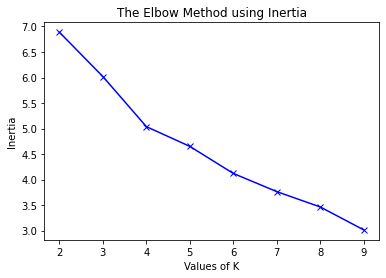

In [25]:
plt.plot(k, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

**From this graph, we can see that the elbow is situated at K = 4. This means that optimal value is K = 4.**

#### C.3. Finalizing the model

Let us now finalize the model using the optimal number of clusters. 

In [26]:
kclusters = 4
data = main_grouped.drop('Address', 1)
final_model = clustering(data, kclusters)

---

## IV. Results

In [27]:
# add clustering labels
def result():
    result_venues =  neighborhoods_venues_sorted
    main_merged = main_data
    print(final_model.labels_)
    
    try:
        result_venues.insert(0, 'Cluster Labels', final_model.labels_)
    except:
        result_venues['Cluster Labels'] = final_model.labels_

    # merge main_grouped with main_data to add latitude/longitude for each neighborhood
    main_merged_final = main_merged.join(result_venues.set_index('Address'), on='Address')
    main_merged_final = main_merged_final.dropna().reset_index(drop=True)
    main_merged_final['Cluster Labels'] = main_merged_final['Cluster Labels'].astype(int)
    return main_merged_final

In [28]:
result_data = result()
result_data.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 0]


,Address,Population,Area,Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Bagumbayan, Taguig City",40685,2.2602,18000.4601,14.477028,121.055009,0,Tennis Court,Park,Pizza Place,Noodle House,Office
1,"Bambang, Taguig City",10010,0.4234,23641.9462,14.524033,121.069340,0,Wings Joint,Convenience Store,Grocery Store,Pharmacy,Spa
2,"Calzada, Taguig City",21747,1.7963,12106.2828,14.530109,121.080803,0,Market,Comfort Food Restaurant,Burger Joint,BBQ Joint,Pool
3,"Central Signal Village, Taguig City",39674,0.7183,55235.4964,14.510621,121.055009,0,Convenience Store,Chinese Restaurant,Asian Restaurant,Burger Joint,Comfort Food Restaurant
4,"Ibayo-Tipas, Taguig City",20932,0.8777,23850.0541,14.538856,121.087251,2,Bakery,American Restaurant,Plaza,Office,Okonomiyaki Restaurant


In [29]:
# create map
map_clusters = folium.Map(location=[visual_center[0], visual_center[1]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result_data['Latitude'], result_data['Longitude'], result_data['Address'], result_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
c1 = result_data.loc[result_data['Cluster Labels'] == 0, result_data.columns[[1] + list(range(5, result_data.shape[1]))]]
c2 = result_data.loc[result_data['Cluster Labels'] == 1, result_data.columns[[1] + list(range(5, result_data.shape[1]))]]
c3 = result_data.loc[result_data['Cluster Labels'] == 2, result_data.columns[[1] + list(range(5, result_data.shape[1]))]]
c4 = result_data.loc[result_data['Cluster Labels'] == 3, result_data.columns[[1] + list(range(5, result_data.shape[1]))]]
c5 = result_data.loc[result_data['Cluster Labels'] == 4, result_data.columns[[1] + list(range(5, result_data.shape[1]))]]

In [31]:
def counter(data):
    
    dict = {}
    categories = ["Food", "Retail", "Liesure", "Essential Service", "Health", "Housing"]
    for category in categories:
        dict[category] = data[data == category].count()
    return dict


# c1["2nd Most Common Venue"][c1["2nd Most Common Venue"] == "Retail"].count()

In [32]:
def count(venue_type):
    table=[]   
    for cluster, text in zip([c1,c2,c3,c4,c5], ["C1", "C2", "C3", "C4", "C5"]):   
        categories = ["Food", "Retail", "Liesure", "Essential Service", "Health", "Housing"]
        for category in categories:
            my_dict = {}
            my_dict["Cluster"] = text
            my_dict["Category"] = category
            my_dict["Count"] = cluster[venue_type][cluster[venue_type] == category].count()
            table.append(my_dict)
    df_table = pd.DataFrame(table)
    return df_table

def plot(data_table):
    g = sns.catplot(
    data=data_table, kind="bar",
    x="Cluster", y="Count", hue="Category",
    ci="sd", palette="bright", alpha=.6, height=6, aspect=2
    )
    g.despine(left=True)
    g.set_axis_labels("", "Count")
    g.legend.set_title("")
    return g

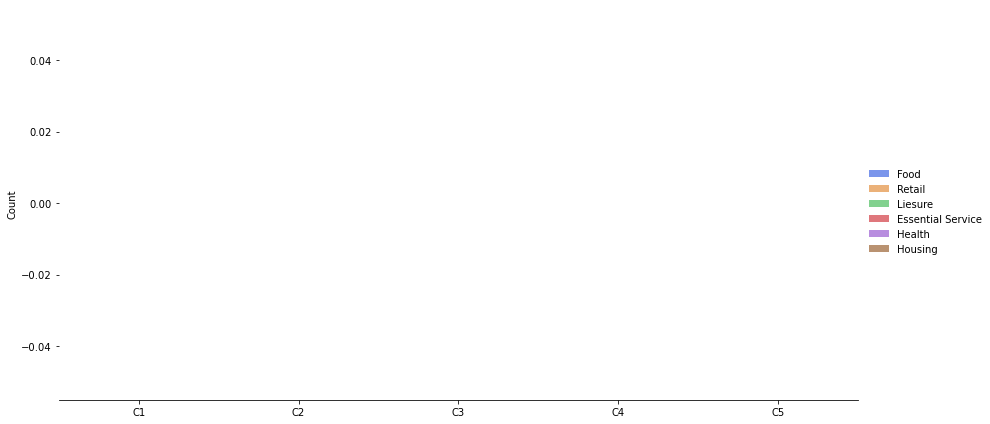

In [33]:
df_table = count(venue_type = "1st Most Common Venue")

k = plot(df_table)
k.savefig("Output.tiff")

In [34]:
result_data.loc[result_data['Cluster Labels'] == 4, result_data.columns[[0] + [-5,-4,-3,-2,-1]]]

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
